<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/classify_Gaussian_blurs_autoencoder_customize_loss_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:

Customize loss functions in three ways.

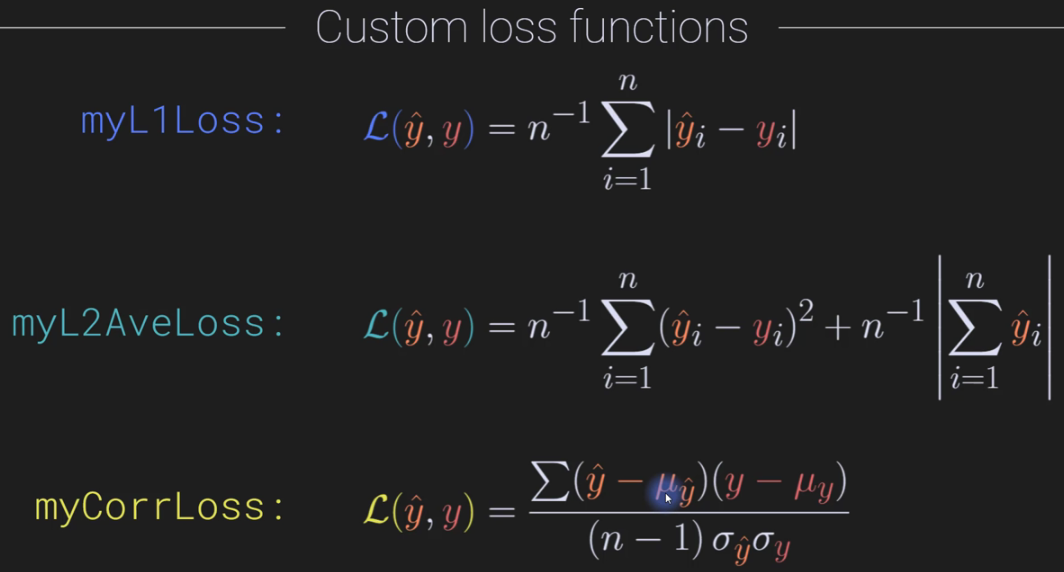

In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [15]:
# scratch:
# generate an array of 2 random values from a normal distribution with a mean of 0 and a standard deviation of 1.5:
tmp = 1.5*np.random.randn(2)
print(tmp)

tmp2 = np.arange(10, 20) # half-open interval [start, stop)
print(tmp2)

tmp3 = np.random.choice(tmp2) # generate a random sample from a given 1D array
print(tmp3)

[-1.74076938 -2.79435622]
[10 11 12 13 14 15 16 17 18 19]
12


In [16]:
# create Gaussian blurs with varying widths and occluding bars:

nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss) # [2., ..., 20.], 1000 elements in total

# initialize images tensor
images = torch.zeros(nGauss,1,imgSize,imgSize)

# loop over images:
for i in range(nGauss):

  # random centers, sampled from a normal distribution (mean=0, sd=1.5)
  ro = 1.5*np.random.randn(2) # ro: random offset

  # Gaussian with random centers
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # add noise: random numbers sampled from a standard normal distribution (mean=0, sd=1)
  G  = G + np.random.randn(imgSize,imgSize)/5
  # print("👀", G.shape) # (91, 91)

  # generate occlusion:
  i1 = np.random.choice(np.arange(2,28)) # start idx from [2,28)
  i2 = np.random.choice(np.arange(2,6))  # end idx from [2, 6)
  if np.random.randn()>0: # generate a single random value from a standard normal distribution (mean=0, sd=1)
    G[i1:i1+i2,] = 1 # horizontal bar
  else:
    G[:,i1:i1+i2] = 1 # vertical bar

  # add occlusion:
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [17]:
images.shape

torch.Size([1000, 1, 91, 91])

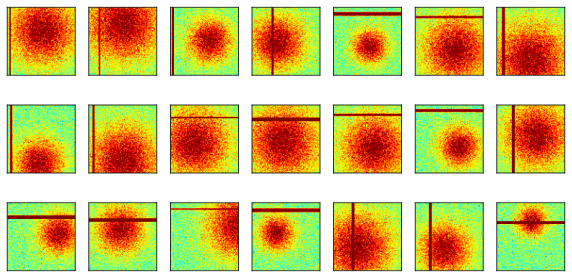

In [18]:
# visualize some images:

fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Customize loss functions:

In [19]:
# L1 loss function:

class myL1Loss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,yHat,y):
    l1 = torch.mean( torch.abs(yHat-y) )
    return l1

In [20]:
# "L2 + average" loss function:

class myL2AveLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,yHat,y):
    # MSE part
    l2 = torch.mean( (yHat-y)**2 )

    # average part
    ave = torch.abs(torch.mean(yHat))

    # sum together
    return l2 + ave

In [21]:
# correlation loss function:

class myCorLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,yHat,y):
    print("👀 y.shape:", y.shape)
    meany = torch.mean(y)
    meanyHat = torch.mean(yHat)

    numerator = torch.sum( (yHat-meanyHat)*(y-meany) )
    denominator = (torch.numel(y)-1) * torch.std(yHat) * torch.std(y)
    # torch.numel(y): calculate the total number of elements in tensor y
    return -numerator/denominator # numerator/denominator -> correlation ("WIN" function), so "-" sign is needed for "LOSS" function

In [22]:
# function to build the model and create a model instance:
def makeTheNet():

  # create a class for the model
  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1), # (inChans, outChans, k, s=1, p=0)
          nn.ReLU(),
          nn.MaxPool2d(2,2), # max pooling
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2), # (inChans, outChans, k, s=1, p=0)
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2), # (inChans, outChans, k, s=1, p=0)
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = myL1Loss()
  # lossfun = myL2AveLoss()
  # lossfun = myCorLoss()
  # lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [23]:
images[0,0,:,:].shape

torch.Size([91, 91])

In [24]:
# a function to train the model:

def function2trainTheModel():

  net,lossfun,optimizer = makeTheNet() # create a new model

  numepochs = 1000
  losses = torch.zeros(numepochs) # initialize losses

  for epochi in range(numepochs):

    pics2use = np.random.choice(nGauss,size=32,replace=False)  # select 32 elements without replacement
    X = images[pics2use,:,:,:] # the image set

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

In [25]:
# train the model:
losses,net = function2trainTheModel()

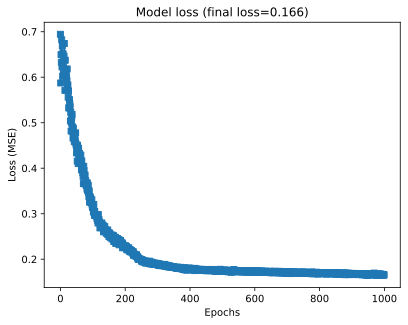

In [26]:
# show the results:

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

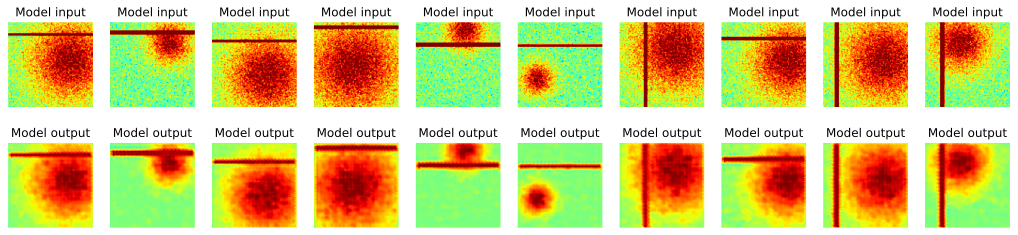

In [27]:
# visualize some images:

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10): # first 10 images

  G = torch.squeeze( X[i,0,:,:] ).detach()    # input image
  O = torch.squeeze( yHat[i,0,:,:] ).detach() # output image

  # fill the 1st row with input images
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  # fill the 2nd row with output images
  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

# Comparison:

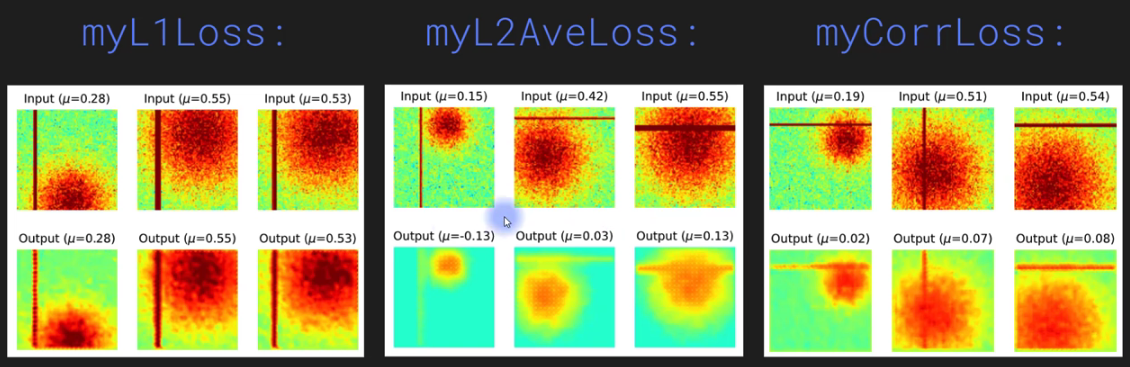

Observations:

---
- All loss functions are effective, with the L1 loss function performing the best.
- With L2 loss function, the average value from this entire map is closer to zero (smaller mean -> dimmer). Because the L2 loss function is not only trying to satisfy the match between the input and the output, and it's also trying to satisfy the average map value and it's trying to get the map value to be as small as possible (kind of a competition going on).